In [2]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow
from tqdm.auto import tqdm

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    FSMOperator, filterFSM, FSM_splot, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, 
    #FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, 
    #alarms_pareto, warnings_pareto, states_lines,
    #detect_edge_right, detect_edge_left, 
    cvset, load_data, get_cycle_data, get_cycle_data2, figures)
    
cred()
mp = MyPlant(0)
Engine._list_cached_validations();
#mp._fetch_installed_base(); # refresh local installed fleet database

In [3]:
def sfun(x):
    return all([ ("Forsa Hartmoor" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [4]:
motor = fleet.iloc[2]
modes = ['undefined','OFF','MAN','AUTO']
success = [True,False]
#success = [True]
e=Engine.from_fleet(mp,motor)
pp_from=e['Commissioning Date']
#pp_from='2022-03-28 06:00'
#pp_to='2022-03-28 08:14'
pp_to=datetime.now()
fsm = FSMOperator(e, p_from=pp_from, p_to=pp_to)
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('Forsa Hartmoor M02', ['undefined', 'OFF', 'MAN', 'AUTO'], [True, False])

In [5]:
fsm.run0(enforce=True, silent=False, debug=False)

FSM: 100%|████████████████████████| 9353/9353 [00:00<00:00, 22146.16 messages/s]


In [6]:
fsm.run1(silent=False, successtime=300, debug=False) # run Finite State Machine

FSM: 100%|█████████████████████████| 9353/9353 [00:02<00:00, 3917.38 messages/s]


In [7]:
fsm.run2(silent = False)

FSM: 100%|█████████████████████████████| 166/166 [01:50<00:00,  1.51 messages/s]


In [8]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
rdb = rda
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")
pd.DataFrame.from_dict(e.dash, orient='index').T

Starts: 166, Successful: 98, Failed: 68 => 59.0%


,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M02,M02,AL87,624,H12,24,4495.0,24.5,1486152,159397,266.0,2022-01-10,54,212.0,0.111


In [9]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(rde[vec].describe().round(2))
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-600,500), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,400)},
    {'col':['startpreparation'],'ylim':(-1000,800)},
    {'col':['hochlauf'],'_ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,6)},
    #{'col':['no'],'ylim':(-100,2000),'color':'rgba(0,0,0,0.3)'},
    {'col':['targetload'],'ylim':(500,5000) },
    {'col':['runout'],'ylim':(0,100) },
    {'col':['count_warnings','count_alarms','no'],'ylim':(-1,200), 'color':['rgba(255,165,0,0.3)','rgba(255,0,0,0.3)','rgba(0,0,0,0.1)'] }
    ]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00,98.00
mean,96.72,20.67,4.73,41.68,111.80,4531.11,0.97,279.59,6988.54,127.02,10.01,50.15
std,17.28,2.32,0.58,23.15,28.99,46.60,0.30,9.48,5990.04,0.12,0.03,1.54
min,0.61,8.38,4.03,1.31,42.72,4365.00,0.55,238.95,436.09,126.74,9.98,47.84
25%,98.71,19.12,4.34,29.12,86.55,4498.25,0.76,277.98,1823.12,126.93,9.99,48.41
50%,100.63,20.48,4.49,46.66,111.31,4525.98,0.93,279.18,5419.22,127.03,9.99,51.14
75%,102.21,22.09,4.85,60.02,132.79,4549.66,1.17,280.46,10770.82,127.09,10.00,51.48
max,168.40,24.94,6.35,81.78,179.58,4642.34,2.38,307.61,37489.88,127.35,10.09,52.10


In [10]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')} CumStart: {startversuch['cumstarttime']:0.1f}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=165), Output()), _do…

In [19]:
for f in figures:
    print(f, end=', ')
for doplot in ['actors','lubrication']:
#for doplot in ['actors']:
    dmaxlength = None
    dminlength = None
    #dmaxlength = 1200
    #dminlength = 200000
    dset = figures[doplot]
    vset = cvset(mp,dset)
    startversuch = rdb.iloc[vv]; 
    try:
        data = get_cycle_data2(fsm, startversuch, max_length=dmaxlength, min_length=dminlength, cycletime=1, silent=True, p_data=cvset(mp,dset))
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        fig = FSM_splot(fsm, startversuch, data, dset, figsize=(18,10))
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    except Exception as err:
        print(err)

starts_overview, actors, lubrication, von: 10.01.2022 11:26:56 bis: 10.01.2022 11:30:27


von: 10.01.2022 11:26:56 bis: 10.01.2022 11:30:27


In [14]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

  0 * |0000| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | off | undefined| 600 10.01.2022 07:19:55 1231 Request module on
  1 * |0001| LST 10.01 07:19:55 LS  startpreparation  | CSS 10.01 07:21:33 CS  starter           | on  | undefined| 600 10.01.2022 07:21:33 1249 Starter on
  2 * |0001| LST 10.01 07:21:33 LS  starter           | CSS 10.01 07:21:37 CS  speedup           | on  | undefined| 600 10.01.2022 07:21:37 3225 Ignition on
  3 * |0001| LST 10.01 07:21:37 LS  speedup           | CSS 10.01 07:21:59 CS  idle              | on  | undefined| 600 10.01.2022 07:21:59 2124 Idle
  4 * |0001| LST 10.01 07:21:59 LS  idle              | CSS 10.01 07:23:06 CS  standstill        | on  | undefined| 600 10.01.2022 07:23:06 3226 Ignition off


In [15]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

  0 * |0000| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | off | undefined| 600 10.01.2022 07:19:55 1231 Request module on
  1   |0001| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | on  | undefined| 600 10.01.2022 07:19:55 1261 Demand oil pump (DC) on
  2   |0001| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | on  | undefined| 600 10.01.2022 07:19:55 1259 Demand oil pump on
  3   |0001| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | on  | undefined| 600 10.01.2022 07:19:55 1257 Demand engine cooling water pump on
  4   |0001| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | on  | undefined| 600 10.01.2022 07:19:58 1282 Demand engine cooling water preheating pump off
  5   |0001| LST 10.01 00:37:14 LS  standstill        | CSS 10.01 07:19:55 CS  startpreparation  | on  | undefined| 600 10.01.2022

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,166.00,125.00,119.00,118.00,118.00,114.00,114.00,166.00,104.00,104.00,104.00,104.00
mean,90.78,20.68,5.63,39.97,108.63,4369.90,0.95,219.04,6593.32,127.02,10.01,50.18
std,68.77,3.06,6.55,23.75,35.30,648.22,0.29,117.35,6030.51,0.12,0.03,1.53
min,0.60,8.38,4.03,0.80,26.04,1192.54,0.48,2.43,40.98,126.74,9.98,47.84
25%,60.63,18.89,4.34,11.14,83.93,4492.78,0.74,173.82,1820.28,126.92,9.99,48.43
50%,100.36,20.36,4.54,45.88,109.23,4518.84,0.81,277.90,5143.15,127.03,9.99,51.12
75%,102.41,22.09,5.35,58.78,131.41,4543.05,1.15,279.74,10183.70,127.09,10.01,51.47
max,450.28,42.56,67.27,81.78,210.09,4642.34,2.38,532.55,37489.88,127.35,10.09,52.10


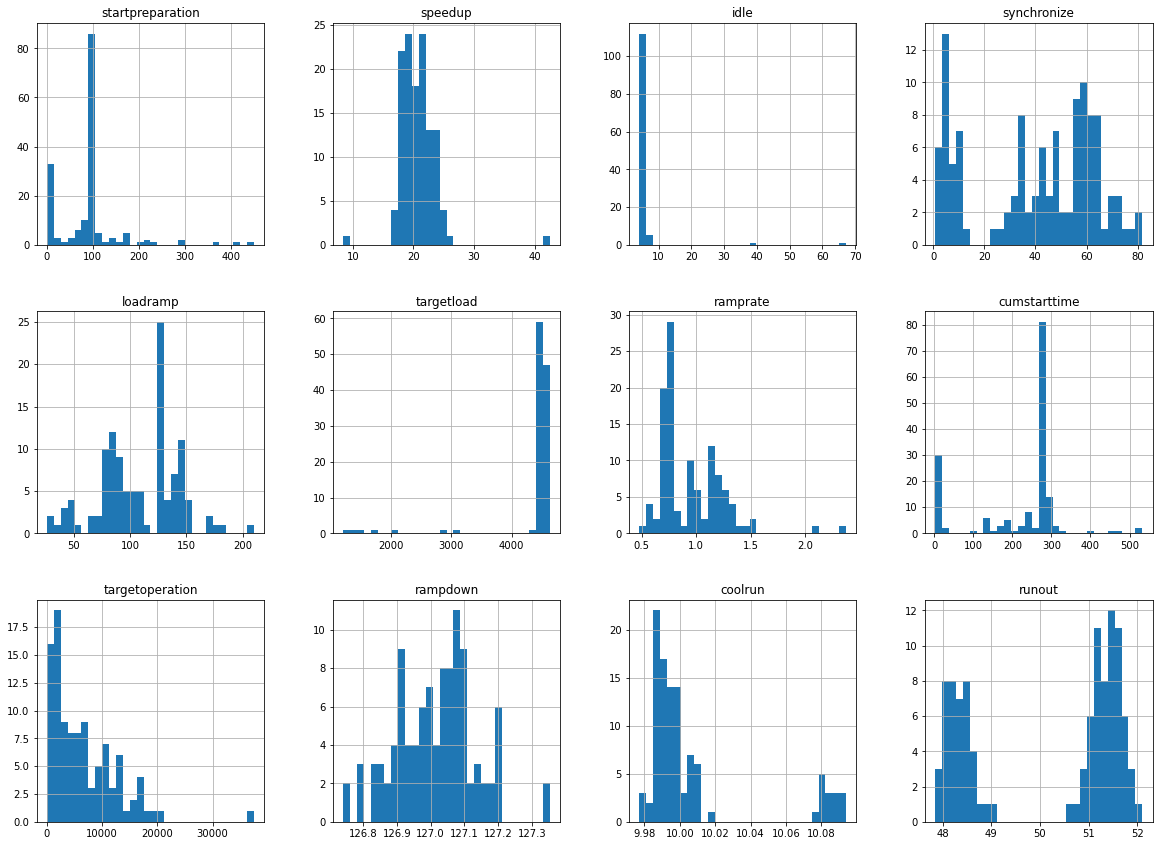

In [16]:
rdb = rda
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,layout=(4,4),figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [17]:
import time
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
t0 = time.time()
for i, startversuch in rdb[-3:].iterrows() : 
#for i, startversuch in tqdm(rdb.iterrows(), total=rdb.shape[0], ncols=80, mininterval=1, unit=' starts', desc="FSM Run2"):
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        #fig = FSM_add_Alarms(fig, fsm, startversuch)
        #fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")
t1 = time.time()
print(f"{(t1-t0):4.1f} sec")    

Start: 163 xmax: 2022-04-02 16:53:11, ymax:   4465, duration: 142.5, ramprate: 0.70 %/s
von: 02.04.2022 16:48:35 bis: 02.04.2022 20:13:14


Start: 164 xmax: 2022-04-03 15:24:46, ymax:   4538, duration: 141.7, ramprate: 0.71 %/s
von: 03.04.2022 15:20:06 bis: 03.04.2022 16:34:13


Start: 165 xmax: 2022-04-04 06:53:17, ymax:   4527, duration: 145.2, ramprate: 0.69 %/s
von: 04.04.2022 06:48:37 bis: 04.04.2022 08:09:16


 2.8 sec


In [18]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

c:\Users\chvatdi00\Documents\Scripts\statemachine\Results/data/1486152/1486152_messages.txt
